In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import os
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer, PowerTransformer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 79 kB/s 


In [ ]:
from catboost import CatBoostRegressor

## 1) Data

###1a. Loading Data

Datasets: total samples - 139708
- X_train_imp_df: 97795 - 70%
- X_test_imp_df: 41913 -30%


In [ ]:
X_train_imp_df = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_train_imp_df')
X_test_imp_df = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_test_imp_df')

In [ ]:
X_train_imp_df.shape, X_test_imp_df.shape

((97795, 28), (41913, 28))

In [ ]:
y_train = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/y_train', squeeze=True)
y_test = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/y_test', squeeze=True)

In [ ]:
y_train.shape, y_test.shape

((97795,), (41913,))

In [ ]:
num_cols=['H', 'albedo', 'epoch', 'e', 'a', 'q', 'i', 'ad', 'n', 'tp', 'per', 'moid', 'moid_jup', 'data_arc', 'condition_code', 'rms']

###1b. Data Standardization
- for Linear Regression and SVR

In [ ]:
#standardize data
def standardize(x_train, x_test):
      x_train_scaled= x_train.copy()
      x_test_scaled = x_test.copy()

      scaler=StandardScaler()
      scaler.fit(x_train_scaled.loc[:, num_cols])

      x_train_scaled.loc[:, num_cols] = scaler.transform(x_train_scaled.loc[:, num_cols])
      x_test_scaled.loc[:, num_cols] = scaler.transform(x_test_scaled.loc[:, num_cols])

      x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns)
      x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_train.columns)

      return x_train_scaled,  x_test_scaled

In [ ]:
X_train_scaled,  X_test_scaled = standardize(X_train_imp_df,  X_test_imp_df)

In [ ]:
X_train_scaled.shape,  X_test_scaled.shape

((97795, 28), (41913, 28))

In [ ]:
X_train_scaled.head()

,H,albedo,epoch,e,a,q,i,ad,n,tp,...,class_APO,class_AST,class_ATE,class_CEN,class_IMB,class_MBA,class_MCA,class_OMB,class_TJN,class_TNO
0,-0.442295,-0.272480,0.092225,-1.293423,0.186582,1.074866,-0.248709,-0.001528,-0.638295,-0.043634,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.391871,-0.537008,0.092225,0.052784,0.110230,0.245165,0.353553,0.071751,-0.464777,-0.411418,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.675093,0.703540,0.092225,-1.347223,0.183262,1.091914,0.215809,-0.008507,-0.630032,-0.191572,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.190071,0.439011,0.092225,0.012435,-0.128784,-0.315546,0.467850,-0.078297,0.204505,-0.349060,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-1.140689,-0.482278,0.092225,-0.054814,0.206500,0.527415,-0.590138,0.120604,-0.679609,-0.771005,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_scaled.to_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_train_scaled', index=False)
X_test_scaled.to_csv('/content/drive/MyDrive/project_asteroid/train_test_split/X_test_scaled', index=False)

In [ ]:
# X_train_scaled = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_train_scaled')
# X_test_scaled = pd.read_csv('/content/drive/MyDrive/project_asteroid/data/X_test_scaled')

## 2) Some utility functions

In [ ]:
#save dataframe to csv
def save_to_csv(dataframe, file_name):
      path = '/content/drive/MyDrive/project_asteroid/train_test_split'
      dataframe.to_csv(os.path.join(path, file_name), index=False) 

In [ ]:
def adjusted_r2(X, y, r2_score):
      adjusted_r_squared = 1 - (1-r2_score)*(len(y)-1)/(len(y)-X.shape[1]-1)
      return adjusted_r_squared

In [ ]:
##defining a function for model evalaution
def model_eval(model, X_train, y_train, X_test, y_test, model_name):
      """function evalutes model and returns result metrics and error"""

      #fitting the model
      model.fit(X_train, y_train)

      #making predictions
      y_pred_train = model.predict(X_train)
      y_pred_test = model.predict(X_test)

      #train error metrics
      mae_train = mean_absolute_error(y_train, y_pred_train)
      med_train = median_absolute_error(y_train, y_pred_train)
      mse_train = mean_squared_error(y_train, y_pred_train)
      rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

      #test error metrics
      mae = mean_absolute_error(y_test, y_pred_test)
      med = median_absolute_error(y_test, y_pred_test)
      mse = mean_squared_error(y_test, y_pred_test)
      rmse = mean_squared_error(y_test, y_pred_test, squared=False)

      #R2 and adjusted R2 score for train, cv, test
      train_score = r2_score(y_train, y_pred_train)
      train_adjust_r2 = adjusted_r2(X_train, y_train, train_score)

      # with Hyperparameter tuning, compute cv score
      cv_scores = cross_val_score(model, X_train, y_train, cv=10)
      #Note:scikit-learn's cross_val_score() uses R^2 score as metric of choice for regression.
      cv_score = np.mean(cv_scores) 
      cv_adjust_r2 = adjusted_r2(X_train, y_train, cv_score)

      test_score = r2_score(y_test, y_pred_test)
      test_adjust_r2 = adjusted_r2(X_test, y_test, test_score)
      
      
      
      print(f"Model:{model_name}")
      print()
      print("TRAINING METRICS")
      print("="*80)
      print("-----------Train error metrics---------")
      print(f"mean absolute error: {mae_train}")
      print(f"median absolute error: {med_train}")
      print(f"mean squared error: {mse_train}")
      print(f"rmse: {rmse_train}")
      print()
      print("---------R2 score & adjusted R2 score------------")
      print(f"train_R2_Score: {train_score}")
      print(f"train adjusted_R2_Score: {train_adjust_r2}")
      print()
    
      print()
      print("EVALUATION ON TEST SET")
      print("="*80)
      print("-------------Test error metrics-------------")
      print(f"mean absolute error: {mae}")
      print(f"median absolute error: {med}")
      print(f"mean squared error: {mse}")
      print(f"rmse: {rmse}")
      print()
      print("---------R2 score & adjusted R2 score------------")
      print(f"test_R2_Score: {test_score}")
      print(f"test adjusted_R2_Score: {test_adjust_r2}")
      print("="*80)

      metrics = [mae, med, mse, rmse, train_score, train_adjust_r2, test_score, test_adjust_r2]
      errors = y_test - y_pred_test


      return model, metrics, y_pred_test, errors


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

##ploting residual graphs
sns.set_style("whitegrid")
def plot_pred_vs_true(y_test, y_pred):
    """function to plot actualvsprediction and residual plots"""

    
    fig, (ax0, ax1)= plt.subplots(ncols=1, nrows=2, figsize=(14,18),gridspec_kw={'height_ratios':[1, 2]})
    fig, (ax0)= plt.subplots(ncols=1, nrows=1, figsize=(12,8))

    #plot actual vs predicted
    ax0.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.2)
    ax0.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.2)

    ax0.set_xlabel('Observations')
    ax0.set_ylabel('diameter')
    ax0.set_yscale('log')
    ax0.legend()
    ax0.set_title('actual and predicted values', fontsize=14)

    # plot residual plot
    sns.residplot(x=y_pred_lr, y=(y_test-y_pred), robust=True, color='red', ax=ax1)
    ax1.set_xlabel('predicted')
    ax1.set_ylabel('residuals')
    ax1.set_ylim([-500, 500])
    ax1.set_title('residual_plot', fontsize=14)

    plt.show()

##3) Modeling

We are experimenting here with a series of Machine Learning Algorithms. This includes:
 - Linear Model, 
 - SVR
 - DecisionTree, RandomForest, 
 - GBDT, XGBoost, AdaBoost, CatBoost,
 - Voting Regressor


**Metrics:**

Main objective metrics would be:
- mean absolute error
- median absolute error

We would also include below metrics inorder to compare with existing solutions available online:
- mean squared error
- RMSE
- R2 score
- Adjusted R2 Score

## 3a. Modeling with basic models (without hyperparameter tuning)

###LinearRegression

In [ ]:
model = LinearRegression()
lr_model, lr_metrics, y_pred_lr, errors_lr = model_eval(model, X_train_scaled, y_train, X_test_scaled, y_test, 'LinearRegression')

Model:LinearRegression

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 2.4968060912300927
median absolute error: 1.601828757540706
mean squared error: 44.768302473849175
rmse: 6.690911931407346

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.5080030721800255
train adjusted_R2_Score: 0.5078621651778064


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 2.5223012731105845
median absolute error: 1.6127675535138795
mean squared error: 38.095792380165506
rmse: 6.172178900531441

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.5008664090843861
test adjusted_R2_Score: 0.5005327317721514


In [ ]:
pickle.dump(lr_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/lr_model.sav', 'wb'))

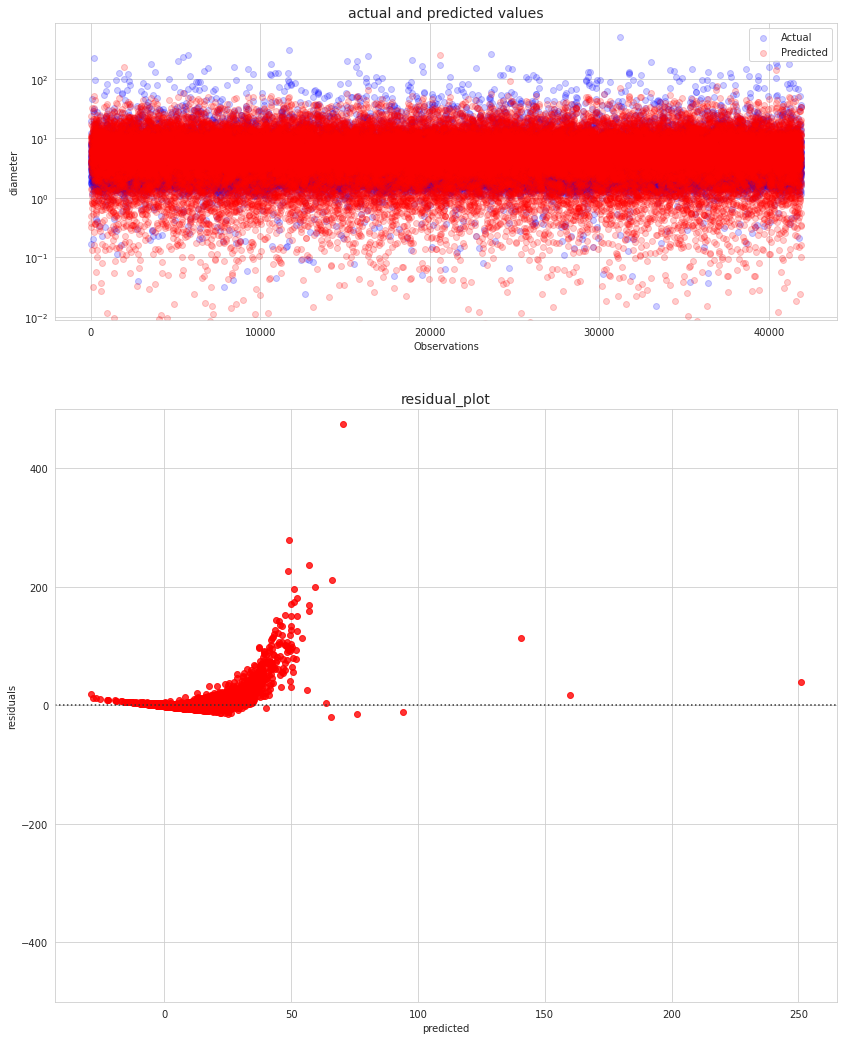

In [ ]:
plot_pred_vs_true(y_test, y_pred_lr)

LinearRegression plot observation:
- actual vs predicted plot - the prediction and actuals are mostly overlapping, model seems not able to predict higher values
- residual plot - residuals variance not constant, residual error display increasing trend with higherpredicted value

Testing Collinearity

In [ ]:
# computing variance_inflation_factor value for the independent variables
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(train_data):
      """ function to compute vif and plot graph, return list of collinear features and new data with removed features"""
      vif = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]
      #dataframe - feature VIF values
      vif_df = pd.DataFrame({'vif_value': vif}, index=train_data.columns).sort_values('vif_value', ascending=False)

      ##plot graph
      xlabels =[i for i in vif_df.index]
      fig, ax = plt.subplots(figsize=(8,4))
      ax = sns.barplot(x=vif_df.index,y="vif_value", data=vif_df)
      ax.set(yscale='log')
      ax.set_xticklabels(labels=xlabels, rotation=70)
      ax.set_title(f'VIF scores for X_train_imp_df')
      plt.plot()


def remove_high_vifs(train_data):
      """ function to compute vif and plot graph, return list of collinear features and new data with removed features"""

      drop = True
      collinear_features = []
      while drop:
          vif = [variance_inflation_factor(train_data.values, i) for i in range(train_data.shape[1])]

          #dataframe - feature VIF values
          vif_df = pd.DataFrame({'vif_value': vif, 'feature':train_data.columns}).sort_values('vif_value', ascending=False)
          vif_max_value = max(vif_df.vif_value.values)

          if vif_max_value >= 5:
              vif_max_feat = vif_df[vif_df.vif_value==vif_max_value].feature.values.item()
              collinear_features.append(vif_max_feat)
              train_data = train_data.drop(vif_max_feat, axis=1)
          else:
              drop=False

      return collinear_features

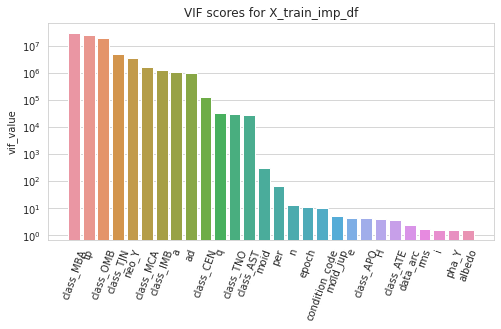

In [ ]:
compute_vif(X_train_imp_df)

- we do observe many features which have vif more than 5

In [ ]:
# identify high collinear features 
high_collinear_features = remove_high_vifs(X_train_imp_df)
print(f"high_collinear_features are: {high_collinear_features}")

high_collinear_features are: ['class_MBA', 'epoch', 'a', 'q', 'tp', 'H', 'ad', 'n', 'rms', 'moid_jup', 'moid']


In [ ]:
X_train_cf_fixed_df = X_train_imp_df.copy()
X_test_cf_fixed_df = X_test_imp_df.copy()

#dropping high collinear features
X_train_cf_fixed_df.drop(high_collinear_features, axis=1, inplace=True)
X_test_cf_fixed_df.drop(high_collinear_features, axis=1, inplace=True)

In [ ]:
numerical_cols = [i for i in num_cols if i not in high_collinear_features]
numerical_cols

['albedo', 'e', 'i', 'per', 'data_arc', 'condition_code']

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_cf_fixed_df.loc[:, numerical_cols])
X_train_cf_fixed_df.loc[:, numerical_cols] = scaler.transform(X_train_cf_fixed_df.loc[:, numerical_cols])
X_test_cf_fixed_df.loc[:, numerical_cols] = scaler.transform(X_test_cf_fixed_df.loc[:, numerical_cols])

In [ ]:
#fitting LinearRegression model after collinearity fix
cf_model, lr_metric_without_collinear_features, y_pred_lr_cf, error_cf = model_eval(model, X_train_cf_fixed_df, y_train, X_test_cf_fixed_df, y_test, 'LinearRegression_on_collinearity_fixed_set')

Model:LinearRegression_on_collinearity_fixed_set

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 2.584718356058052
median absolute error: 1.4532472459930212
mean squared error: 56.42103815889452
rmse: 7.51139388921221

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.3799412552038419
train adjusted_R2_Score: 0.3798334486781606


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 2.6286223268090536
median absolute error: 1.4788575720664978
mean squared error: 46.65713315215724
rmse: 6.83060269318581

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.38869515615616634
test adjusted_R2_Score: 0.38844710311056796


- collinearity fix doesn't improve model performance

###SVR

In [ ]:
model = SVR()
svr_model, svr_metrics, y_pred_svr, errors_svr = model_eval(model, X_train_scaled, y_train, X_test_scaled, y_test, 'SVR')

Model:SVR

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.6291671815142877
median absolute error: 0.2087498716561269
mean squared error: 38.52203328145057
rmse: 6.20661206145918

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.5766486335075252
train adjusted_R2_Score: 0.5765273864659995


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.6161898620702916
median absolute error: 0.2153404686045466
mean squared error: 23.24945327178547
rmse: 4.821768687088325

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.6953841258224372
test adjusted_R2_Score: 0.6951804861395757


In [ ]:
pickle.dump(svr_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/svr_model.sav', 'wb'))

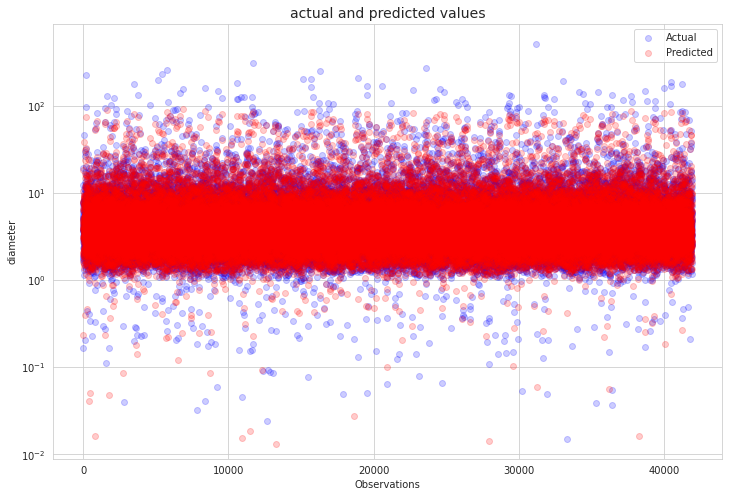

In [ ]:
plot_pred_vs_true(y_test, y_pred_svr)

SVR plot observation:
- actual vs predicted plot - the prediction and actuals are  overlapping in most region, model seems to make mistake at both higher and lower values

### Decision Tree

In [ ]:
model = DecisionTreeRegressor()
dt_model, dt_metrics, y_pred_dt, errors_dt = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'DecisionTreeRegressor')

Model:DecisionTreeRegressor

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.0
median absolute error: 0.0
mean squared error: 0.0
rmse: 0.0

---------R2 score & adjusted R2 score------------
train_R2_Score: 1.0
train adjusted_R2_Score: 1.0


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.5831524348054302
median absolute error: 0.30200000000000005
mean squared error: 6.700212033068499
rmse: 2.5884767785453473

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.912213378879535
test adjusted_R2_Score: 0.9121546923789292


In [ ]:
pickle.dump(dt_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/dt_model.sav', 'wb'))

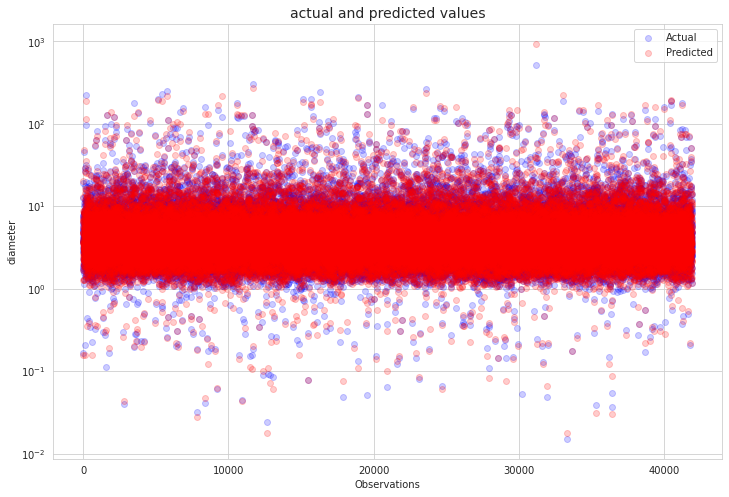

In [ ]:
plot_pred_vs_true(y_test, y_pred_dt)

DecisionTree plot observation:
- actual vs predicted plot - the prediction and actuals are mostly overlapping, model seems to predict well


### Random Forest

In [ ]:
model = RandomForestRegressor(n_jobs=-1)
rf_model, rf_metrics, y_pred_rf, errors_rf = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'RandomForestRegressor')

Model:RandomForestRegressor

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.15293544107571966
median absolute error: 0.07747999999999466
mean squared error: 0.5346822997025854
rmse: 0.7312197342130377

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.994123921742017
train adjusted_R2_Score: 0.9941222388441668


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.40088784732660515
median absolute error: 0.20908000000000193
mean squared error: 1.9713046537704288
rmse: 1.4040315715005944

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.974171836070343
test adjusted_R2_Score: 0.97415456960606


In [ ]:
pickle.dump(rf_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/rf_model.sav', 'wb'))

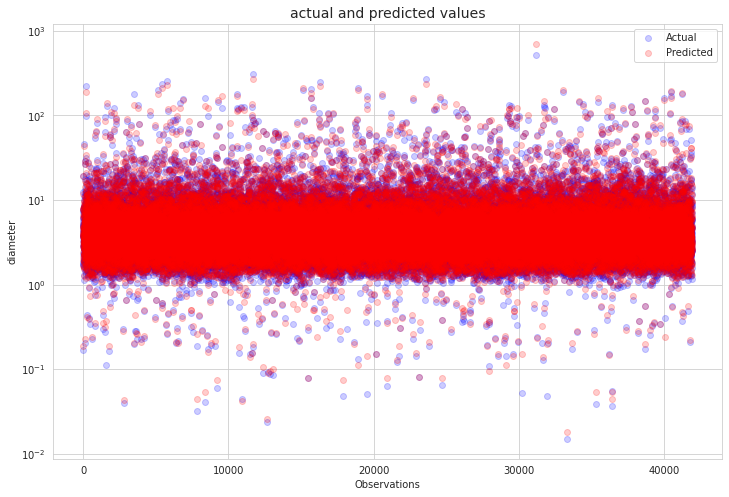

In [ ]:
plot_pred_vs_true(y_test, y_pred_rf)

RandomForest plot observation:
- actual vs predicted plot - the prediction and actuals are very well overlapping, model seems to predict well

### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor()
gbdt_model, gbdt_metrics, y_pred_gbdt, errors_gbdt = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test,'GBDT')

Model:GBDT

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.4536597023320236
median absolute error: 0.27413850278515106
mean squared error: 0.8968482009548261
rmse: 0.9470206972156554

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.9901437728212189
train adjusted_R2_Score: 0.9901409500161434


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.46961298591141676
median absolute error: 0.27743437273091676
mean squared error: 1.4623756641864356
rmse: 1.2092872546200244

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.9808398573456891
test adjusted_R2_Score: 0.980827048540553


In [ ]:
pickle.dump(gbdt_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/gbdt_model.sav', 'wb'))

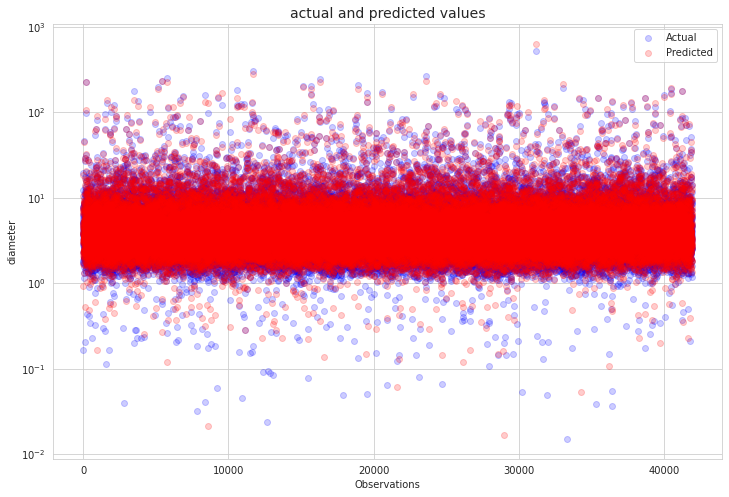

In [ ]:
plot_pred_vs_true(y_test, y_pred_gbdt)

GBDT plot observation:
- actual vs predicted plot - the prediction and actuals are mostly overlapping, model seems to make mistake at lower values

### AdaBoost

In [ ]:
model = AdaBoostRegressor()
ada_model, ada_metrics, y_pred_ada, errors_ada = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test,'AdaBoost')

Model:AdaBoost

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 2.3775600189291435
median absolute error: 2.105234347292329
mean squared error: 11.144381497555022
rmse: 3.338320161032345

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.8775249192784635
train adjusted_R2_Score: 0.8774898426438441


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 2.368212553078336
median absolute error: 2.0887656527076714
mean squared error: 11.090904333604374
rmse: 3.3303009373935524

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.8546862380157311
test adjusted_R2_Score: 0.8545890938715338


In [ ]:
pickle.dump(ada_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/ada_model.sav', 'wb'))

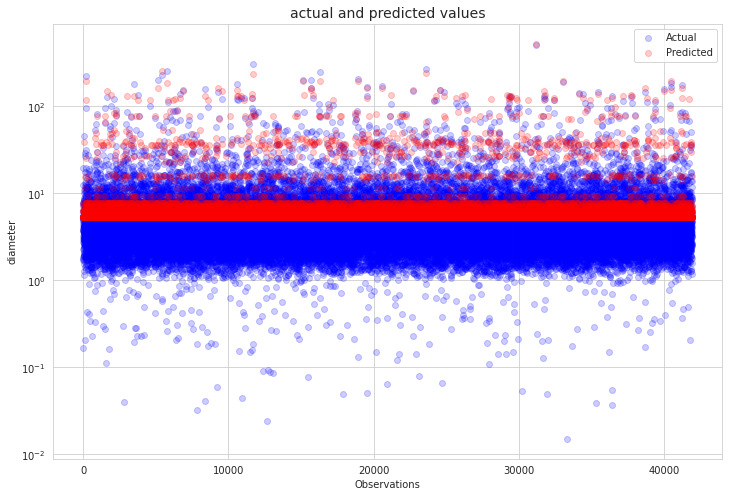

In [ ]:
plot_pred_vs_true(y_test, y_pred_ada)

AdaBoost plot observation:
- actual vs predicted plot - model doesn't seems to be able to make predication well for the lower values at all


###XGBoost

In [ ]:
model = XGBRegressor()
xg_model, xg_metrics, y_pred_xg, errors_xg = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'XGBRegressor')

[05:12:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model:XGBRegressor

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.4665531164956499
median absolute error: 0.28365617370605456
mean squared error: 0.9377863399537876
rmse: 0.9683936905792951

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.9896938688153674
train adjusted_R2_Score: 0.989690917158624


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.48825355786177427
median absolute error: 0.2880422248840331
mean squared error: 2.298378296610551
rmse: 1.5160403347571432

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.9698864955735368
test adjusted_R2_Score: 0.9698663643032679


In [ ]:
pickle.dump(xg_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/xg_model.sav', 'wb'))

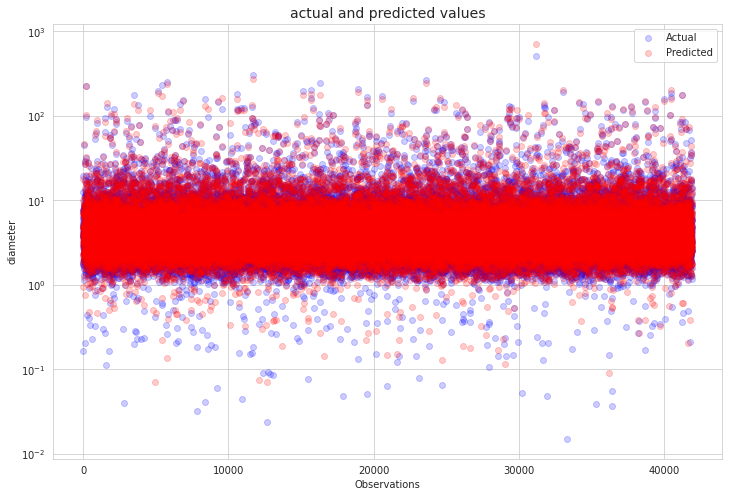

In [ ]:
plot_pred_vs_true(y_test, y_pred_xg)

XGBoost plot observation:
- actual vs predicted plot - the prediction and actuals are mostly overlapping, model seems to make mistake at lower values

### CatBoost

In [ ]:
model = CatBoostRegressor()
ct_model, ct_metrics, y_pred_ct, errors_ct = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'CatBoostRegressor')

Learning rate set to 0.08446
0:	learn: 8.9934084	total: 132ms	remaining: 2m 11s
1:	learn: 8.4987391	total: 202ms	remaining: 1m 40s
2:	learn: 8.0559737	total: 262ms	remaining: 1m 26s
3:	learn: 7.6702482	total: 314ms	remaining: 1m 18s
4:	learn: 7.3120472	total: 359ms	remaining: 1m 11s
5:	learn: 6.9859080	total: 419ms	remaining: 1m 9s
6:	learn: 6.6930741	total: 478ms	remaining: 1m 7s
7:	learn: 6.4433655	total: 540ms	remaining: 1m 6s
8:	learn: 6.2050860	total: 592ms	remaining: 1m 5s
9:	learn: 5.9814625	total: 663ms	remaining: 1m 5s
10:	learn: 5.7830815	total: 713ms	remaining: 1m 4s
11:	learn: 5.6125366	total: 771ms	remaining: 1m 3s
12:	learn: 5.4547430	total: 823ms	remaining: 1m 2s
13:	learn: 5.3032611	total: 885ms	remaining: 1m 2s
14:	learn: 5.1766499	total: 941ms	remaining: 1m 1s
15:	learn: 5.0494892	total: 998ms	remaining: 1m 1s
16:	learn: 4.9364731	total: 1.03s	remaining: 59.4s
17:	learn: 4.8339981	total: 1.05s	remaining: 57.3s
18:	learn: 4.7340749	total: 1.07s	remaining: 55.2s
19:	lea

In [ ]:
pickle.dump(ct_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/ct_model.sav', 'wb'))

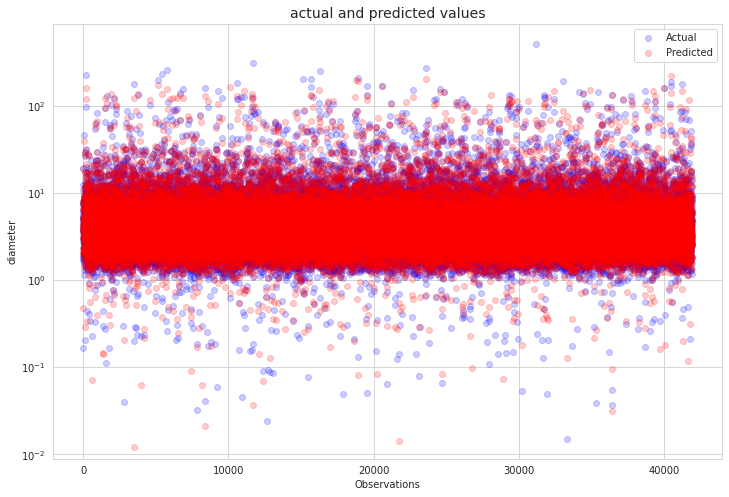

In [ ]:
plot_pred_vs_true(y_test, y_pred_ct)

CatBoost plot observation:
- actual vs predicted plot - the prediction and actuals are mostly overlapping, model seems to make mistake at lower values

### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMRegressor()
lgbm_model, lgbm_metrics, y_pred_lgbm, errors_lgbm = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'LightGBMRegressor')

Model:LightGBMRegressor

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.47642990117853207
median absolute error: 0.25049436925071555
mean squared error: 9.384665017413857
rmse: 3.063440062644258

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.8968639393936302
train adjusted_R2_Score: 0.8968344014182913


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.5566328035703153
median absolute error: 0.25224719904265136
mean squared error: 13.372001976141899
rmse: 3.6567748052268545

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.824799145861646
test adjusted_R2_Score: 0.8246820218067354


In [ ]:
pickle.dump(lgbm_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/lgbm_model.sav', 'wb'))

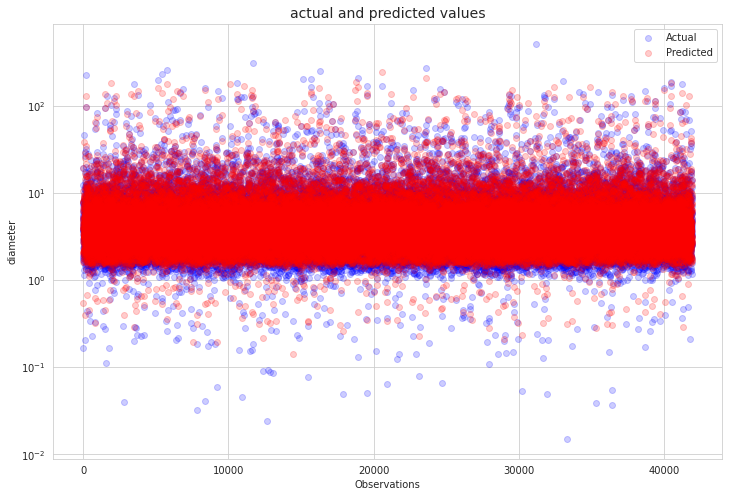

In [ ]:
plot_pred_vs_true(y_test, y_pred_lgbm)

LightGBM plot observation:
- actual vs predicted plot - the prediction and actuals are mostly overlapping, model seems to make mistake at lower values

### VotingRegressor
Considering top 5 models:
  - DecisionTree
  - RandomForest
  - GBDT 
  - XGBoost
  - CatBoost

In [ ]:
model = VotingRegressor(
    estimators=[('rf', rf_model), ('gbdt', gbdt_model),('xg', xg_model),('dt', dt_model)])
vot_model3, vot_metrics3, y_pred_vot3, errors_vot3 = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'VotingRegressor')

[10:10:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model:VotingRegressor

TRAINING METRICS
-----------Train error metrics---------
mean absolute error: 0.26025692039576553
median absolute error: 0.15435514491259994
mean squared error: 0.34940387672975626
rmse: 0.5911039474828064

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.9961601038140804
train adjusted_R2_Score: 0.9961590040749767


EVALUATION ON TEST SET
-------------Test error metrics-------------
mean absolute error: 0.4321208842571653
median absolute error: 0.2407910967685578
mean squared error: 1.524831669606483
rmse: 1.2348407466578364

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.9800215546326634
test adjusted_R2_Score: 0.9800081987814963


In [ ]:
model = VotingRegressor(
    estimators=[('rf', rf_model), ('gbdt', gbdt_model),('xg', xg_model),('dt', dt_model),('ct', ct_model)])
vot_model2, vot_metrics2, y_pred_vot2, errors_vot2 = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'VotingRegressor')

[09:53:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Learning rate set to 0.08446
0:	learn: 8.9934084	total: 35.9ms	remaining: 35.9s
1:	learn: 8.4987391	total: 56.4ms	remaining: 28.1s
2:	learn: 8.0559737	total: 75.9ms	remaining: 25.2s
3:	learn: 7.6702482	total: 92.8ms	remaining: 23.1s
4:	learn: 7.3120472	total: 111ms	remaining: 22.1s
5:	learn: 6.9859080	total: 128ms	remaining: 21.3s
6:	learn: 6.6930741	total: 146ms	remaining: 20.7s
7:	learn: 6.4433655	total: 163ms	remaining: 20.2s
8:	learn: 6.2050860	total: 185ms	remaining: 20.4s
9:	learn: 5.9814625	total: 202ms	remaining: 20s
10:	learn: 5.7830815	total: 221ms	remaining: 19.9s
11:	learn: 5.6125366	total: 238ms	remaining: 19.6s
12:	learn: 5.4547430	total: 261ms	remaining: 19.8s
13:	learn: 5.3032611	total: 281ms	remaining: 19.8s
14:	learn: 5.1766499	total: 299ms	remaining: 19.6s
15:	learn: 5.0494892	total: 316ms	remaining: 19.4s
16:	learn: 4.9364731	total: 332ms	re

In [ ]:
pickle.dump(vot_model2, open('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/vot_model.sav', 'wb'))

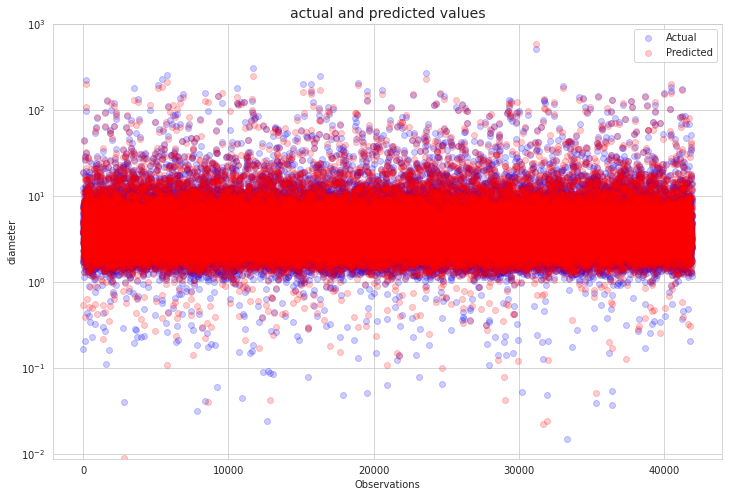

In [ ]:
plot_pred_vs_true(y_test, y_pred_vot2)

Plot Observation:
- model performs well, we still some issues with predicting the lower diameter values

### Result Summary - Model without hyperparameter tuning

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "MeanAE", "MedianAE", "MSE", "RMSE", "train_R2", "test_R2"]
x.align["Model"] = "l"
x.add_row(['LinearRegression', lr_metrics[0], lr_metrics[1], lr_metrics[2], lr_metrics[3], lr_metrics[4], lr_metrics[6]])
x.add_row(['SVR', svr_metrics[0], svr_metrics[1], svr_metrics[2], svr_metrics[3], svr_metrics[4],  svr_metrics[6]])
x.add_row(['DecisionTreeRegressor', dt_metrics[0], dt_metrics[1], dt_metrics[2], dt_metrics[3], dt_metrics[4], dt_metrics[6]])
x.add_row(['RandomForestRegressor', rf_metrics[0], rf_metrics[1], rf_metrics[2], rf_metrics[3], rf_metrics[4], rf_metrics[6]])
x.add_row(['GradientBoosting', gbdt_metrics[0], gbdt_metrics[1], gbdt_metrics[2], gbdt_metrics[3], gbdt_metrics[4], gbdt_metrics[6]])
x.add_row(['AdaBoost', ada_metrics[0], ada_metrics[1], ada_metrics[2], ada_metrics[3], ada_metrics[4], ada_metrics[6]])
x.add_row(['XGBoost', xg_metrics[0], xg_metrics[1], xg_metrics[2], xg_metrics[3], xg_metrics[4], xg_metrics[6]])
x.add_row(['CatBoost', ct_metrics[0], ct_metrics[1], ct_metrics[2], ct_metrics[3], ct_metrics[4], ct_metrics[6]])
x.add_row(['LGBM', lgbm_metrics[0], lgbm_metrics[1], lgbm_metrics[2], lgbm_metrics[3], lgbm_metrics[4], lgbm_metrics[6]])
x.add_row(['VotingRegressor', vot_metrics2[0], vot_metrics2[1], vot_metrics2[2], vot_metrics2[3], vot_metrics2[4], vot_metrics2[6]])
print(x.get_string(title="Model metrics (without hyperparameter tuning)"))

+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                     Model metrics (without hyperparameter tuning)                                                     |
+-----------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
| Model                 |        MeanAE       |       MedianAE      |        MSE         |        RMSE        |      train_R2      |      test_R2       |
+-----------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
| LinearRegression      |  2.5223012731105845 |  1.6127675535138795 | 38.095792380165506 | 6.172178900531441  | 0.5080030721800255 | 0.5008664090843861 |
| SVR                   |  0.6161898620702916 |  0.2153404686045466 | 23.249

In [ ]:
#creating metrics dataframe
mae, med_ae, mse, rmse, tr_r2, tr_a_r2, t_r2, t_a_r2 = [], [], [], [], [], [], [], []
metrics = [mae, med_ae, mse, rmse, tr_r2, tr_a_r2, t_r2, t_a_r2]
model_metric = [lr_metrics, svr_metrics, dt_metrics, rf_metrics, gbdt_metrics, ada_metrics, xg_metrics, ct_metrics, lgbm_metrics, vot_metrics2]
algo_list = ['LinearRegression', 'SVR', 'DecisionTree', 'RandomForest', 'GBDT', 'AdaBoost', 'XGBosst', 'CatBoost', 'LGBM', 'VotingRegressor']

for i in range(len(metrics)):
      for j in range(len(algo_list)):
          metrics[i].append(model_metric[j][i])
metrics_df = pd.DataFrame({"Algorithms":algo_list, "MeanAE": mae, "MedianAE": med_ae, "MSE": mse, "RMSE":rmse, "train_R2":tr_r2, "train_adjust_R2":tr_a_r2,  "test_R2":t_r2, "test_adjust_R2":t_a_r2})

#saving the metrics dataframe
# metrics_df.to_csv('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/metrics_df', index=False)
metrics_df = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/untuned_models/metrics_df')

#### Plotting 'mean_absolute_error' and 'test_R2_score' across tested models

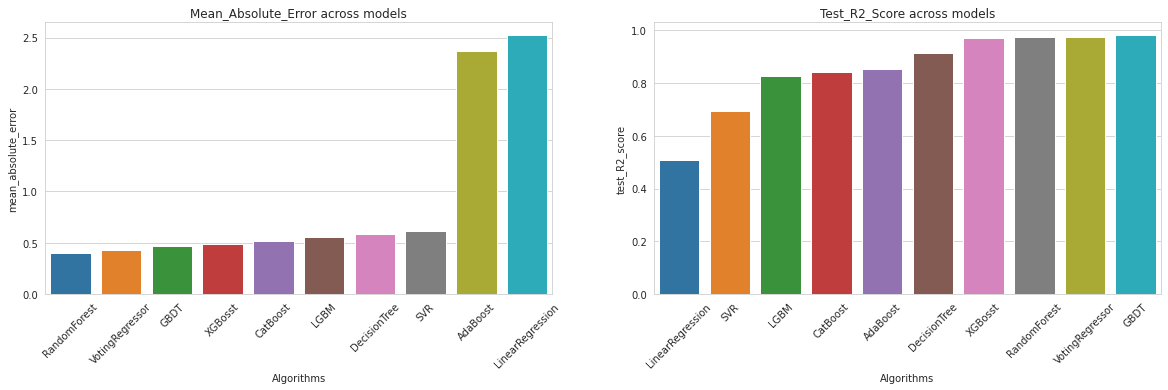

In [ ]:
#plotting the mean_absolute_error and test_R2_score across tested models

fig , (ax1 , ax2) = plt.subplots(1,2 , figsize = (20,5))

order1 = metrics_df.sort_values('MeanAE').Algorithms
labels1 = metrics_df.sort_values('MeanAE').Algorithms.values

sns.barplot(x=metrics_df['Algorithms'], y=metrics_df['MeanAE'], ax=ax1, order=order1)
ax1.set_xticklabels(labels1, rotation=45)
ax1.set_ylabel("mean_absolute_error")
ax1.set_title("Mean_Absolute_Error across models")

order2 = metrics_df.sort_values('test_R2').Algorithms
labels2 = metrics_df.sort_values('test_R2').Algorithms.values

sns.barplot(x=metrics_df['Algorithms'], y=metrics_df['test_R2'], ax=ax2, order=order2)
ax2.set_xticklabels(labels2, rotation=45)
ax2.set_ylabel("test_R2_score")
ax2.set_title("Test_R2_Score across models")

plt.show()

#### **Top 3 Best Models** - 
- 1. GradientBoostingRegressor 
- 2. VotingRegressor
- 3. RandomForestRegressor

### BEST MODEL: GradientBoosting Regressor Metric details



```
TRAINING METRICS
================================================================================
-----------Train error metrics---------
mean absolute error: 0.4536597023320236
median absolute error: 0.27413850278515106
mean squared error: 0.8968482009548261
rmse: 0.9470206972156554

---------R2 score & adjusted R2 score------------
train_R2_Score: 0.9901437728212189
train adjusted_R2_Score: 0.9901409500161434


EVALUATION ON TEST SET
================================================================================
-------------Test error metrics-------------
mean absolute error: 0.46961298591141676
median absolute error: 0.27743437273091676
mean squared error: 1.4623756641864356
rmse: 1.2092872546200244

---------R2 score & adjusted R2 score------------
test_R2_Score: 0.9808398573456891
test adjusted_R2_Score: 0.980827048540553
================================================================================
```



## 3b. Hyperparameter Tuning and Modeling
- Tuning only the best perfomers from above list, which are mostly the Tree Based models
- tuning using RandomizedSearchCV

In [ ]:
##defining a function for model evalaution
def model_eval(model, X_train, y_train, X_test, y_test, model_name):
      """function evalutes model and returns result metrics and error"""

      #fitting the model
      model.fit(X_train, y_train)

      #making predictions
      y_pred_train = model.predict(X_train)
      y_pred_test = model.predict(X_test)

      #train error metrics
      mae_train = mean_absolute_error(y_train, y_pred_train)
      med_train = median_absolute_error(y_train, y_pred_train)
      mse_train = mean_squared_error(y_train, y_pred_train)
      rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

      #test error metrics
      mae = mean_absolute_error(y_test, y_pred_test)
      med = median_absolute_error(y_test, y_pred_test)
      mse = mean_squared_error(y_test, y_pred_test)
      rmse = mean_squared_error(y_test, y_pred_test, squared=False)

      #R2 and adjusted R2 score for train, cv, test
      train_score = r2_score(y_train, y_pred_train)
      train_adjust_r2 = adjusted_r2(X_train, y_train, train_score)

      cv_scores = cross_val_score(model, X_train, y_train, cv=10)
      cv_score = np.mean(cv_scores) #By default, scikit-learn's cross_val_score() function uses R^2 score as the metric of choice for regression.
      cv_adjust_r2 = adjusted_r2(X_train, y_train, cv_score)

      test_score = r2_score(y_test, y_pred_test)
      test_adjust_r2 = adjusted_r2(X_test, y_test, test_score)
      
      
      
      print(f"Model:{model_name}")
      print()
      print("TRAINING & CROSS VALIDATION METRICS")
      print("="*80)
      print("-----------train and cross-validations error metrics---------")
      print(f"mean absolute error: {mae_train}")
      print(f"median absolute error: {med_train}")
      print(f"mean squared error: {mse_train}")
      print(f"rmse: {rmse_train}")
      print()
      print("---------R2 score & Adjusted R2 score------------")
      print(f"train_R2_Score: {train_score}")
      print(f"train adjusted_R2_Score: {train_adjust_r2}")
      print()
      print(f"cross_val_score R2: {cv_score}")
      print(f"cross_val adjusted_R2_Score: {cv_adjust_r2}")
      
      print()
      print("EVALUATION ON TEST SET")
      print("="*80)
      print("-------------Test set error metrics-------------")
      print(f"mean absolute error: {mae}")
      print(f"median absolute error: {med}")
      print(f"mean squared error: {mse}")
      print(f"rmse: {rmse}")
      print()
      print("---------R2 score & Adjusted R2 score------------")
      print(f"test_R2_Score: {test_score}")
      print(f"test adjusted_R2_Score: {test_adjust_r2}")
      print("="*80)

      metrics = [mae, med, mse, rmse, train_score, train_adjust_r2, cv_score, cv_adjust_r2, test_score, test_adjust_r2]
      errors = y_test - y_pred_test


      return model, metrics, y_pred_test, errors


### DecisionTree

Hyperparameter tuning using RandomizedSearchCV

In [ ]:
#parameters
params_dt = {
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_split': [3, 5, 10, 20],
    'min_samples_leaf': [1, 5, 10, 20, 50, 100]
}


dt = DecisionTreeRegressor(random_state=42)
dt_randomCV = RandomizedSearchCV(estimator=dt, 
                               param_distributions=params_dt,
                               cv=10, random_state=42, n_jobs=-1, return_train_score=True)

dt_randomCV.fit(X_train_imp_df, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 30, 40, 50],
                                        'min_samples_leaf': [1, 5, 10, 20, 50,
                                                             100],
                                        'min_samples_split': [3, 5, 10, 20]},
                   random_state=42, return_train_score=True)

In [ ]:
print(f"best_estimators: {dt_randomCV.best_estimator_}")
print(f"best_params: {dt_randomCV.best_params_}")
print(f"best_score: {dt_randomCV.best_score_}")
print(f"mean_train_score: {dt_randomCV.cv_results_['mean_train_score']}")
print(f"mean_test_score: {dt_randomCV.cv_results_['mean_test_score']}")

best_estimators: DecisionTreeRegressor(max_depth=40, min_samples_split=5, random_state=42)
best_params: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 40}
best_score: 0.9264542413183244
mean_train_score: [0.78832485 0.80531277 0.89011127 0.98772158 0.89010016 0.83330858
 0.85158231 0.81965782 0.81965782 0.80531277]
mean_test_score: [0.84898118 0.8388419  0.89303738 0.92645424 0.89304832 0.86197032
 0.8815014  0.85547446 0.85547446 0.8388419 ]


In [ ]:
#fitting train with best hyperparameters
model = DecisionTreeRegressor(max_depth=40, min_samples_split=5, random_state=42)

# model-fitting, predictions and evaluation
dt_model_tuned, dt_metrics_tuned, y_pred_dt_tuned, errors_dt_tuned = model_eval(model, X_train_imp_df, y_train,  X_test_imp_df, y_test, 'DecisionTreeRegressor')

Model:DecisionTreeRegressor

TRAINING & CROSS VALIDATION METRICS
-----------train and cross-validations error metrics---------
mean absolute error: 0.09918732467576734
median absolute error: 0.034999999999999254
mean squared error: 1.2387751538714062
rmse: 1.1130027645389773

---------R2 score & Adjusted R2 score------------
train_R2_Score: 0.9863860469062801
train adjusted_R2_Score: 0.9863821478955133

cross_val_score R2: 0.9264542413183244
cross_val adjusted_R2_Score: 0.9264331779502508

EVALUATION ON TEST SET
-------------Test set error metrics-------------
mean absolute error: 0.5724388912747835
median absolute error: 0.2999999999999998
mean squared error: 4.370753269109856
rmse: 2.090634657014433

---------R2 score & Adjusted R2 score------------
test_R2_Score: 0.942734101644443
test adjusted_R2_Score: 0.9426958186448738


In [ ]:
# save the model to disk
pickle.dump(dt_model_tuned, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/dt_model_tuned.sav', 'wb'))
 
# load the model from disk
# dt_model_tuned = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/dt_model_tuned.sav', 'rb'))

### RandomForest

Hyperparameter tuning by RandomizedSearchCV

In [ ]:
%%time 
params= { 'max_depth': [10, 20, 30, 40, 50, 70],
 'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],
 'n_estimators': [100, 200, 400, 600, 800]}

rf = RandomForestRegressor(random_state=42)
rf_randomCV = RandomizedSearchCV(estimator=rf, 
                               param_distributions=params,
                               cv=10,random_state=42, n_jobs=-1, return_train_score=True)

rf_randomCV.fit(X_train_imp_df, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 9min 45s, sys: 11.6 s, total: 9min 57s
Wall time: 3h 54min 24s


In [ ]:
print(f"best_estimators: {rf_randomCV.best_estimator_}")
print(f"best_params: {rf_randomCV.best_params_}")
print(f"best_score: {rf_randomCV.best_score_}")
print()
print(f"mean_train_score: {rf_randomCV.cv_results_['mean_train_score']}")
print(f"mean_test_score: {rf_randomCV.cv_results_['mean_test_score']}")


best_estimators: RandomForestRegressor(max_depth=70, min_samples_leaf=5, n_estimators=400,
                      random_state=42)
best_params: {'n_estimators': 400, 'min_samples_leaf': 5, 'max_depth': 70}
best_score: 0.9285879895696143

mean_train_score: [0.76198715 0.76192433 0.88957694 0.83825964 0.81419825 0.85771057
 0.89061198 0.92619639 0.92421212 0.83835985]
mean_test_score: [0.83093707 0.8317562  0.91830046 0.88925928 0.87537213 0.89827372
 0.91553269 0.92858799 0.92828134 0.8881588 ]


In [ ]:
# defining model with best hyperparameter
model = RandomForestRegressor(max_depth=70, min_samples_leaf=5, n_estimators=400, random_state=42)

# model-fitting, predictions and evaluation
rf_model_tuned, rf_metrics_tuned, y_pred_rf_tuned, errors_rf_tuned = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'RandomForestRegressor')

Model:RandomForestRegressor

TRAINING & CROSS VALIDATION METRICS
-----------train and cross-validations error metrics---------
mean absolute error: 0.2689565889814654
median absolute error: 0.12465590237775626
mean squared error: 6.578563497941754
rmse: 2.564871048988965

---------R2 score & Adjusted R2 score------------
train_R2_Score: 0.927702574107057
train adjusted_R2_Score: 0.9276818682591651

cross_val_score R2: 0.9285879895696143
cross_val adjusted_R2_Score: 0.928567537303059

EVALUATION ON TEST SET
-------------Test set error metrics-------------
mean absolute error: 0.40577890185107995
median absolute error: 0.20674989243141084
mean squared error: 3.280829322269724
rmse: 1.8113059714663682

---------R2 score & Adjusted R2 score------------
test_R2_Score: 0.9570143572690635
test adjusted_R2_Score: 0.9569856208065368


In [ ]:
# save the model to disk
pickle.dump(rf_model_tuned, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/rf_model_tuned.sav', 'wb'))
 
# load the model from disk
# rf_tuned_model = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/rf_tuned_model.sav', 'rb'))

###GradientBoosting

Hyperparameter tuning using RandomizedSearchCV

In [ ]:
params_gbdt={'n_estimators':[250, 350, 500, 750, 1000],
             'learning_rate':[.001, 0.01,.1, 0.5],
             'max_depth':[2, 3, 4, 5, 6, 7, 8],
             'subsample':[0.75, 1]}

gbdt = GradientBoostingRegressor(random_state=42)
gdbt_randomCV = RandomizedSearchCV(estimator=gbdt, 
                               param_distributions=params_gbdt,
                               cv=10,random_state=42, n_jobs=-1, return_train_score=True)

gdbt_randomCV.fit(X_train_imp_df, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.5],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'n_estimators': [250, 350, 500, 750,
                                                         1000],
                                        'subsample': [0.75, 1]},
                   random_state=42, return_train_score=True)

In [ ]:
print(f"best_estimators: {gdbt_randomCV.best_estimator_}")
print(f"best_params: {gdbt_randomCV.best_params_}")
print(f"best_score: {gdbt_randomCV.best_score_}")

print()
print(f"mean_train_scores: {gdbt_randomCV.cv_results_['mean_train_score']}")
print(f"mean_test_scores: {gdbt_randomCV.cv_results_['mean_test_score']}")


best_estimators: GradientBoostingRegressor(n_estimators=500, random_state=42, subsample=1)
best_params: {'subsample': 1, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.1}
best_score: 0.9615094999882816

mean_train_scores: [0.48593464 0.99463841 0.99781671 0.99969968 0.99488974 0.6954545
 0.9927464  0.99852715 0.99148852 0.99460204]
mean_test_scores: [0.4686049  0.95063546 0.94513435 0.93972403 0.95941963 0.64974633
 0.95744632 0.93912031 0.95711856 0.9615095 ]


In [ ]:
# defining model with best hyperparameter
model = GradientBoostingRegressor(n_estimators=500, random_state=42, subsample=1)

# model-fitting, predictions and evaluation
gbdt_tuned_model, gbdt_metrics_tuned, y_pred_gbdt_tuned, errors_gbdt_tuned = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test,'GBDT')

Model:GBDT

TRAINING & CROSS VALIDATION METRICS
-----------train and cross-validations error metrics---------
mean absolute error: 0.38729452582354046
median absolute error: 0.23329653951080176
mean squared error: 0.5037878702543895
rmse: 0.7097801562838943

---------R2 score & Adjusted R2 score------------
train_R2_Score: 0.9944634468867138
train adjusted_R2_Score: 0.9944618612282317

cross_val_score R2: 0.9615094999882816
cross_val adjusted_R2_Score: 0.9614984763808891

EVALUATION ON TEST SET
-------------Test set error metrics-------------
mean absolute error: 0.4274474884383637
median absolute error: 0.23710788202865896
mean squared error: 2.151819091366893
rmse: 1.4669080037162838

---------R2 score & Adjusted R2 score------------
test_R2_Score: 0.9718067239721222
test adjusted_R2_Score: 0.9717878763995699


In [ ]:
# save the model to disk
pickle.dump(gbdt_tuned_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/gbdt_tuned_model.sav', 'wb'))
 
# load the model from disk
# gbdt_tuned_model = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/gbdt_tuned_model.sav', 'rb'))

### AdaBoost

Hyperparameter tuning using RandomizedSearchCV

In [ ]:
%%time 

params_ada= {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0], 'n_estimators':[2,3,5,7,9,11,13,15,17,19]}

ada = AdaBoostRegressor(random_state=42)
ada_randomCV = RandomizedSearchCV(estimator=ada, 
                               param_distributions=params_ada,
                               cv=10,random_state=42, n_jobs=-1, return_train_score=True)

ada_randomCV.fit(X_train_imp_df, y_train)

CPU times: user 13.6 s, sys: 520 ms, total: 14.1 s
Wall time: 6min 56s


In [ ]:
print(f"best_estimators: {ada_randomCV.best_estimator_}")
print(f"best_params: {ada_randomCV.best_params_}")
print(f"best_score: {ada_randomCV.best_score_}")
print()
print(f"mean_train_scores: {ada_randomCV.cv_results_['mean_train_score']}")
print(f"mean_test_scores: {ada_randomCV.cv_results_['mean_test_score']}")

best_estimators: AdaBoostRegressor(learning_rate=0.1, n_estimators=19, random_state=42)
best_params: {'n_estimators': 19, 'learning_rate': 0.1}
best_score: 0.8271852770553003

mean_train_scores: [0.85330058 0.89782514 0.82113603 0.88980364 0.86232403 0.89380061
 0.86347768 0.86242627 0.87133721 0.85588207]
mean_test_scores: [0.79956238 0.82718528 0.75420891 0.81065082 0.79679252 0.81455363
 0.78167225 0.78208816 0.80377288 0.79584129]


In [ ]:
# defining model with best hyperparameter
model = AdaBoostRegressor(learning_rate=0.1, n_estimators=19, random_state=42)

# model-fitting, predictions and evaluation
ada_model_tuned, ada_metrics_tuned, y_pred_ada_tuned, errors_ada_tuned = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test,'AdaBoost')

Model:AdaBoost

TRAINING & CROSS VALIDATION METRICS
-----------train and cross-validations error metrics---------
mean absolute error: 1.8132934545544641
median absolute error: 1.3735826188619846
mean squared error: 9.11421452099228
rmse: 3.0189757403782296

---------R2 score & Adjusted R2 score------------
train_R2_Score: 0.8998361497749492
train adjusted_R2_Score: 0.8998074630351184

cross_val_score R2: 0.8271852770553003
cross_val adjusted_R2_Score: 0.8271357832410658

EVALUATION ON TEST SET
-------------Test set error metrics-------------
mean absolute error: 1.8149047889823227
median absolute error: 1.374373713745809
mean squared error: 9.041503963780132
rmse: 3.006909370729376

---------R2 score & Adjusted R2 score------------
test_R2_Score: 0.8815376171813406
test adjusted_R2_Score: 0.8814584235341502


In [ ]:
# save the model to disk

pickle.dump(ada_model_tuned, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/ada_model_tuned.sav', 'wb'))
 
# load the model from disk
# ada_model_tuned = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/ada_model_tuned.sav', 'rb'))

###XGBoost

Hyperparameter tuning using RandomizedSearchCV

In [ ]:
params_xgb = {'max_depth': [2, 3, 5, 6, 7, 8], 'gamma':[0, 0.1, 0.2], 
              'n_estimators':[100, 250, 300, 450, 550, 600, 750],
              'reg_alpha': [0.1, 3, 5, 8, 11, 13, 15, 17, 19],
              'learning_rate':[0.01, 0.1, 0.3, 0.5]}

xg = XGBRegressor(random_state=42)
xg_randomCV = RandomizedSearchCV(estimator=xg, 
                               param_distributions=params_xgb,
                               cv=10,random_state=42, n_jobs=-1, return_train_score=True)
xg_randomCV.fit(X_train_imp_df, y_train)

[21:13:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=10, estimator=XGBRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.3, 0.5],
                                        'max_depth': [2, 3, 5, 6, 7, 8],
                                        'n_estimators': [100, 250, 300, 450,
                                                         550, 600, 750],
                                        'reg_alpha': [0.1, 3, 5, 8, 11, 13, 15,
                                                      17, 19]},
                   random_state=42, return_train_score=True)

In [ ]:
print(f"best_estimators: {xg_randomCV.best_estimator_}")
print(f"best_params: {xg_randomCV.best_params_}")
print(f"best_score: {xg_randomCV.best_score_}")
print()
print(f"mean_train_scores: {xg_randomCV.cv_results_['mean_train_score']}")
print(f"mean_test_scores: {xg_randomCV.cv_results_['mean_test_score']}")

best_estimators: XGBRegressor(gamma=0.2, max_depth=2, n_estimators=550, random_state=42,
             reg_alpha=15)
best_params: {'reg_alpha': 15, 'n_estimators': 550, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.2}
best_score: 0.9650445275607883

mean_train_scores: [0.99577029 0.99889325 0.71468602 0.99243755 0.99819239 0.99059807
 0.98026821 0.99881271 0.77164804 0.99190541]
mean_test_scores: [0.95766753 0.95152887 0.68097827 0.96032122 0.9506678  0.96504453
 0.94374661 0.94920083 0.7519865  0.95440437]


In [ ]:
# defining model with best hyperparameter
model = XGBRegressor(gamma=0.2, max_depth=2, n_estimators=550, random_state=42, reg_alpha=15)


# model-fitting, predictions and evaluation
xg_model_tuned, xg_metrics_tuned, y_pred_xg_tuned, errors_xg_tuned = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'XGBRegressor')

[06:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:13:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:14:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:15:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:16:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# save the model to disk
pickle.dump(xg_model_tuned, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/xg_model_tuned.sav', 'wb'))
 
# load the model from disk
# xg_model_tuned = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/xg_model_tuned.sav', 'rb'))

###CatBoost

Hyperparameter tuning using RandomizedSearchCV

In [ ]:
params_ct = {
    "n_estimators": [400, 500, 600],
    "learning_rate": [0.001, 0.1, 0.2,0.3],
    "colsample_bylevel":[0.01, 0.1],
    "max_depth": [5, 6, 7, 8, 10, 13]}


ct = CatBoostRegressor(random_state=42)
ct_randomCV = RandomizedSearchCV(estimator=ct, 
                               param_distributions=params_ct,
                               cv=10,random_state=42, n_jobs=-1, return_train_score=True)

ct_randomCV.fit(X_train_imp_df, y_train)

0:	learn: 9.5390279	total: 7.27ms	remaining: 3.63s
1:	learn: 9.4013537	total: 17.7ms	remaining: 4.41s
2:	learn: 8.9513027	total: 32.8ms	remaining: 5.43s
3:	learn: 8.4720142	total: 48ms	remaining: 5.95s
4:	learn: 8.0580134	total: 61.9ms	remaining: 6.13s
5:	learn: 7.7033443	total: 77.9ms	remaining: 6.42s
6:	learn: 7.5800557	total: 93.5ms	remaining: 6.59s
7:	learn: 7.2838157	total: 108ms	remaining: 6.65s
8:	learn: 7.2353096	total: 134ms	remaining: 7.29s
9:	learn: 6.9824292	total: 151ms	remaining: 7.4s
10:	learn: 6.7182211	total: 162ms	remaining: 7.22s
11:	learn: 6.6938751	total: 171ms	remaining: 6.96s
12:	learn: 6.4947474	total: 183ms	remaining: 6.84s
13:	learn: 6.2669725	total: 198ms	remaining: 6.86s
14:	learn: 6.0896268	total: 218ms	remaining: 7.04s
15:	learn: 5.9384187	total: 233ms	remaining: 7.06s
16:	learn: 5.7281065	total: 249ms	remaining: 7.08s
17:	learn: 5.7048340	total: 259ms	remaining: 6.94s
18:	learn: 5.7048295	total: 264ms	remaining: 6.69s
19:	learn: 5.6974968	total: 271ms	rem

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fa8cf310a90>,
                   n_jobs=-1,
                   param_distributions={'colsample_bylevel': [0.01, 0.1],
                                        'learning_rate': [0.001, 0.1, 0.2, 0.3],
                                        'max_depth': [5, 6, 7, 8, 10, 13],
                                        'n_estimators': [400, 500, 600]},
                   random_state=42, return_train_score=True)

In [ ]:
print(f"best_params: {ct_randomCV.best_params_}")
print(f"best_score: {ct_randomCV.best_score_}")
print()
print(f"train_mean_scores: {ct_randomCV.cv_results_['mean_train_score']}")
print(f"test_mean_scores: {ct_randomCV.cv_results_['mean_test_score']}")

best_params: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bylevel': 0.1}
best_score: 0.8390185234479344

train_mean_scores: [0.98537196 0.55497986 0.29799408 0.96846635 0.65908321 0.0123869
 0.98715612 0.66364347 0.6476028  0.53123797]
test_mean_scores: [0.82473648 0.5826579  0.3124322  0.83901852 0.67527208 0.01337721
 0.83623647 0.6804766  0.66462265 0.56277827]


In [ ]:
# defining model with best hyperparameter
model = CatBoostRegressor(n_estimators=500, max_depth=7, learning_rate=0.1, colsample_bylevel=0.1, random_state=42)

# model-fitting, predictions and evaluation
ct_model_tuned, ct_metrics_tuned, y_pred_ct_tuned, errors_ct_tuned = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'CatBoostRegressor')

Streaming output truncated to the last 5000 lines.
29:	learn: 4.9891958	total: 253ms	remaining: 3.96s
30:	learn: 4.9086568	total: 263ms	remaining: 3.99s
31:	learn: 4.8538137	total: 274ms	remaining: 4s
32:	learn: 4.7735417	total: 282ms	remaining: 3.99s
33:	learn: 4.7295603	total: 292ms	remaining: 4s
34:	learn: 4.6644294	total: 301ms	remaining: 4s
35:	learn: 4.6258176	total: 310ms	remaining: 4s
36:	learn: 4.5743949	total: 320ms	remaining: 4s
37:	learn: 4.5668525	total: 327ms	remaining: 3.98s
38:	learn: 4.5311376	total: 337ms	remaining: 3.98s
39:	learn: 4.5148103	total: 346ms	remaining: 3.98s
40:	learn: 4.4759251	total: 356ms	remaining: 3.99s
41:	learn: 4.4323257	total: 366ms	remaining: 3.99s
42:	learn: 4.4154213	total: 372ms	remaining: 3.96s
43:	learn: 4.3725112	total: 382ms	remaining: 3.96s
44:	learn: 4.3283883	total: 391ms	remaining: 3.95s
45:	learn: 4.3265443	total: 396ms	remaining: 3.9s
46:	learn: 4.2566298	total: 408ms	remaining: 3.93s
47:	learn: 4.2439600	total: 413ms	remaining: 3.

In [ ]:
# save the model to disk
pickle.dump(ct_model_tuned, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/ct_model_tuned.sav', 'wb'))
 
# load the model from disk
# ct_model_tuned = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/ct_model_tuned.sav', 'rb'))

### Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
%%time 
params_lgb={'n_estimators': [400,600,700,800],
'max_depth': [3, 5, 6, 7, 9],
'num_leaves': [15, 20, 30, 50],
'feature_fraction': [0.5, 0.6, 0.7],
'bagging_fraction': [0.7, 0.8],
'learning_rate':[0.07, 0.1]}

lgbm = lgb.LGBMRegressor()
lgb_randomCV = RandomizedSearchCV(estimator=lgbm, 
                               param_distributions=params_lgb,
                               cv=10,random_state=42, n_jobs=-1, return_train_score=True)

lgb_randomCV.fit(X_train_imp_df, y_train)

CPU times: user 6.71 s, sys: 476 ms, total: 7.19 s
Wall time: 10min 6s


In [ ]:
print(f"best_estimators: {lgb_randomCV.best_estimator_}")
print(f"best_params: {lgb_randomCV.best_params_}")
print(f"best_score: {lgb_randomCV.best_score_}")
print()
print(f"mean_train_scores: {lgb_randomCV.cv_results_['mean_train_score']}")
print(f"mean_test_scores: {lgb_randomCV.cv_results_['mean_test_score']}")

best_estimators: LGBMRegressor(bagging_fraction=0.7, feature_fraction=0.7, learning_rate=0.07,
              max_depth=3, n_estimators=800, num_leaves=30)
best_params: {'num_leaves': 30, 'n_estimators': 800, 'max_depth': 3, 'learning_rate': 0.07, 'feature_fraction': 0.7, 'bagging_fraction': 0.7}
best_score: 0.8231772474562888

mean_train_scores: [0.92346401 0.9776217  0.91636018 0.88707005 0.94996055 0.92828492
 0.94746701 0.86463163 0.88045492 0.96791032]
mean_test_scores: [0.81518173 0.78832019 0.80823432 0.81957009 0.79607359 0.80830012
 0.80515257 0.82317725 0.8224633  0.79065705]


In [ ]:
#defining model with best hyperparameter
model = lgb.LGBMRegressor(bagging_fraction=0.7, feature_fraction=0.7, learning_rate=0.07, max_depth=3, n_estimators=800, num_leaves=30)

# model-fitting, predictions and evaluation
lgbm_model_tuned, lgbm_metrics_tuned, y_pred_lgbm_tuned, errors_lgbm_tuned = model_eval(model, X_train_imp_df, y_train,  X_test_imp_df, y_test, 'LighGBMRegresssor')

Model:LighGBMRegresssor

TRAINING & CROSS VALIDATION METRICS
-----------train and cross-validations error metrics---------
mean absolute error: 0.5849639679113999
median absolute error: 0.28138112127518555
mean squared error: 13.245838966610977
rmse: 3.6394833378669253

---------R2 score & Adjusted R2 score------------
train_R2_Score: 0.8544302169648386
train adjusted_R2_Score: 0.8543885260505638

cross_val_score R2: 0.8231772474562888
cross_val adjusted_R2_Score: 0.8231266057498549

EVALUATION ON TEST SET
-------------Test set error metrics-------------
mean absolute error: 0.6180482517856809
median absolute error: 0.28324201620248246
mean squared error: 13.996878787994063
rmse: 3.74124027402599

---------R2 score & Adjusted R2 score------------
test_R2_Score: 0.8166119685516905
test adjusted_R2_Score: 0.8164893712620201


In [ ]:
# save the model to disk
pickle.dump(lgbm_model_tuned, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/lgbm_model_tuned.sav', 'wb'))
 
# load the model from disk
# lgbm_model_tuned = pickle.load(open('/content/drive/MyDrive/project_asteroid/train_test_split/models/lgbm_model_tuned.sav', 'rb'))

### VotingRegressor with Tuned models
Considering top 5 models:
  - DecisionTree
  - RandomForest
  - GBDT 
  - XGBoost
  - CatBoost

In [ ]:
model = VotingRegressor(
    estimators=[('rf', rf_model_tuned), ('gbdt', gbdt_tuned_model),('xg', xg_model_tuned),('dt', dt_model_tuned),('ct', ct_model_tuned)])
vot_model, vot_metrics, y_pred_vot, errors_vot = model_eval(model, X_train_imp_df, y_train, X_test_imp_df, y_test, 'VotingRegressor')

Streaming output truncated to the last 5000 lines.
38:	learn: 4.5311376	total: 384ms	remaining: 4.54s
39:	learn: 4.5148103	total: 399ms	remaining: 4.59s
40:	learn: 4.4759251	total: 411ms	remaining: 4.6s
41:	learn: 4.4323257	total: 422ms	remaining: 4.6s
42:	learn: 4.4154213	total: 429ms	remaining: 4.56s
43:	learn: 4.3725112	total: 440ms	remaining: 4.56s
44:	learn: 4.3283883	total: 451ms	remaining: 4.57s
45:	learn: 4.3265443	total: 458ms	remaining: 4.52s
46:	learn: 4.2566298	total: 469ms	remaining: 4.52s
47:	learn: 4.2439600	total: 474ms	remaining: 4.47s
48:	learn: 4.2327080	total: 485ms	remaining: 4.46s
49:	learn: 4.2141391	total: 497ms	remaining: 4.47s
50:	learn: 4.1835534	total: 505ms	remaining: 4.45s
51:	learn: 4.1603086	total: 515ms	remaining: 4.43s
52:	learn: 4.1603079	total: 520ms	remaining: 4.39s
53:	learn: 4.1499724	total: 531ms	remaining: 4.38s
54:	learn: 4.1201307	total: 542ms	remaining: 4.38s
55:	learn: 4.0888028	total: 555ms	remaining: 4.4s
56:	learn: 4.0877430	total: 560ms	

In [ ]:
pickle.dump(vot_model, open('/content/drive/MyDrive/project_asteroid/train_test_split/models/vot_model.sav', 'wb'))

### Result Summary

Result after hyperparameter tuning

In [ ]:
from prettytable import PrettyTable
x = PrettyTable(columns_width=10, autowrap=True, linebreaks=True)

x.field_names = ["Model", "MAE", "MedianAE", "MSE", "RMSE", "train_R2", "train_adjust_R2", "cv_R2", "cv_adjust_R2", "test_R2", "test_adjust_R2"]
x.align["Model"] = "l"
x.add_row(['DecisionTree', dt_metrics_tuned[0], dt_metrics_tuned[1], dt_metrics_tuned[2], dt_metrics_tuned[3], dt_metrics_tuned[4], dt_metrics_tuned[5], dt_metrics_tuned[6], dt_metrics_tuned[7], dt_metrics_tuned[8], dt_metrics_tuned[9]])
x.add_row(['RandomForest', rf_metrics_tuned[0], rf_metrics_tuned[1], rf_metrics_tuned[2], rf_metrics_tuned[3], rf_metrics_tuned[4], rf_metrics_tuned[5], rf_metrics_tuned[6], rf_metrics_tuned[7], rf_metrics_tuned[8], rf_metrics_tuned[9]])
x.add_row(['GBDT',  gbdt_metrics_tuned[0], gbdt_metrics_tuned[1], gbdt_metrics_tuned[2], gbdt_metrics_tuned[3], gbdt_metrics_tuned[4], gbdt_metrics_tuned[5], gbdt_metrics_tuned[6], gbdt_metrics_tuned[7], gbdt_metrics_tuned[8], gbdt_metrics_tuned[9]])
x.add_row(['AdaBoost', ada_metrics_tuned[0], ada_metrics_tuned[1], ada_metrics_tuned[2], ada_metrics_tuned[3], ada_metrics_tuned[4], ada_metrics_tuned[5], ada_metrics_tuned[6], ada_metrics_tuned[7], ada_metrics_tuned[8], ada_metrics_tuned[9]])
x.add_row(['XGBoost', xg_metrics_tuned[0], xg_metrics_tuned[1], xg_metrics_tuned[2], xg_metrics_tuned[3], xg_metrics_tuned[4], xg_metrics_tuned[5], xg_metrics_tuned[6], xg_metrics_tuned[7], xg_metrics_tuned[8], xg_metrics_tuned[9]])
x.add_row(['CatBoost', ct_metrics_tuned[0], ct_metrics_tuned[1], ct_metrics_tuned[2], ct_metrics_tuned[3], ct_metrics_tuned[4], ct_metrics_tuned[5], ct_metrics_tuned[6], ct_metrics_tuned[7], ct_metrics_tuned[8], ct_metrics_tuned[9]])
x.add_row(['LGBM', lgbm_metrics_tuned[0], lgbm_metrics_tuned[1], lgbm_metrics_tuned[2], lgbm_metrics_tuned[3], lgbm_metrics_tuned[4], lgbm_metrics_tuned[5], lgbm_metrics_tuned[6], lgbm_metrics_tuned[7], lgbm_metrics_tuned[8], lgbm_metrics_tuned[9]])
x.add_row(['VotingRegressor', vot_metrics[0], vot_metrics[1], vot_metrics[2], vot_metrics[3], vot_metrics[4], vot_metrics[5], vot_metrics[6], vot_metrics[7], vot_metrics[8], vot_metrics[9]])
print(x.get_string(title="Model metrics after hyperparameter tuning"))

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                              Model metrics after hyperparameter tuning                                                                                              |
+-----------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Model           |         MAE         |       MedianAE      |        MSE         |        RMSE        |      train_R2      |  train_adjust_R2   |       cv_R2        |    cv_adjust_R2    |      test_R2       |   test_adjust_R2   |
+-----------------+---------------------+---------------------+---------

In [ ]:
#creating metrics dataframe
mae, med_ae, mse, rmse, tr_r2, tr_a_r2, cv_r2, cv_a_r2, t_r2, t_a_r2 = [], [], [], [], [], [], [], [], [], []
metrics = [mae, med_ae, mse, rmse, tr_r2, tr_a_r2, cv_r2, cv_a_r2, t_r2, t_a_r2]
model_metric = [dt_metrics_tuned, rf_metrics_tuned, gbdt_metrics_tuned, ada_metrics_tuned, xg_metrics_tuned, ct_metrics_tuned, lgbm_metrics_tuned, vot_metrics]
algo_list = ['DecisionTree', 'RandomForest', 'GBDT', 'AdaBoost', 'XGBosst', 'CatBoost', 'LGBM', 'VotingRegressor']

for i in range(len(metrics)):
      for j in range(len(algo_list)):
          metrics[i].append(model_metric[j][i])
tuned_model_metrics_df = pd.DataFrame({"Algorithms":algo_list, "MeanAE": mae, "MedianAE": med_ae, "MSE": mse, "RMSE":rmse, "train_R2":tr_r2, "train_adjust_R2":tr_a_r2, "cv_R2":cv_r2, "cv_adjust_R2":cv_a_r2, "test_R2":t_r2, "test_adjust_R2":t_a_r2})

#saving the metrics dataframe
tuned_model_metrics_df.to_csv('/content/drive/MyDrive/project_asteroid/train_test_split/models/tuned_model_metrics_df', index=False)
#tuned_model_metrics_df = pd.read_csv('/content/drive/MyDrive/project_asteroid/train_test_split/models/tuned_model_metrics_df')

#### Plotting 'mean_absolute_error' and 'test_R2_score' across tested models

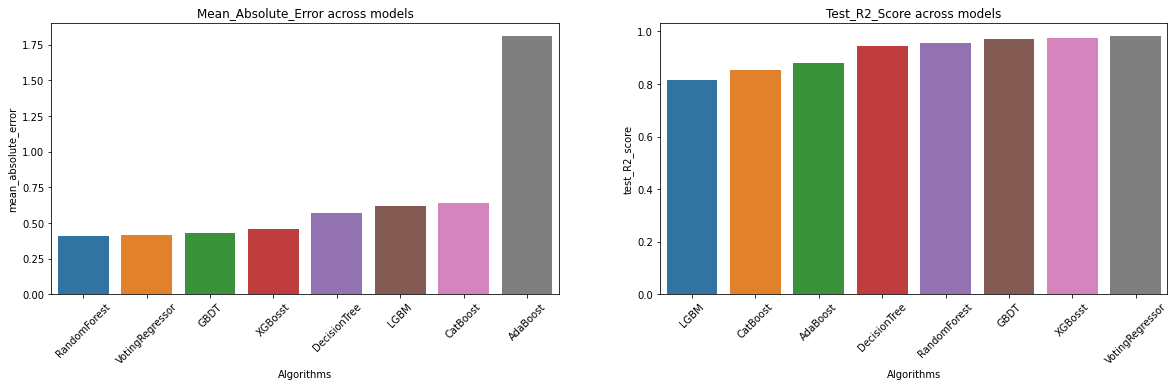

In [ ]:
#plotting the mean_absolute_error and test_R2_score across tested models

fig , (ax1 , ax2) = plt.subplots(1,2 , figsize = (20,5))

order1 = tuned_model_metrics_df.sort_values('MeanAE').Algorithms
labels1 = tuned_model_metrics_df.sort_values('MeanAE').Algorithms.values

sns.barplot(x=tuned_model_metrics_df['Algorithms'], y=tuned_model_metrics_df['MeanAE'], ax=ax1, order=order1)
ax1.set_xticklabels(labels1, rotation=45)
ax1.set_ylabel("mean_absolute_error")
ax1.set_title("Mean_Absolute_Error across models")

order2 = tuned_model_metrics_df.sort_values('test_R2').Algorithms
labels2 = tuned_model_metrics_df.sort_values('test_R2').Algorithms.values

sns.barplot(x=tuned_model_metrics_df['Algorithms'], y=tuned_model_metrics_df['test_R2'], ax=ax2, order=order2)
ax2.set_xticklabels(labels2, rotation=45)
ax2.set_ylabel("test_R2_score")
ax2.set_title("Test_R2_Score across models")

plt.show()

#### **Top 3 Best Tuned Models** - 
- 1. VotingRegressor
- 2. XGBoostRegressor
- 3. GradientBoostingRegressor

## BEST MODEL: VotingRegressor with tuned models

- Voting Regressor gave a slightly better R2 score of 0.9843 compared to the best untuned GBDT model with score 0.980
- Error metrics also improved 


```
TRAINING & CROSS VALIDATION METRICS
================================================================================
-----------train and cross-validations error metrics---------
mean absolute error: 0.3061456289057487
median absolute error: 0.17447922103120295
mean squared error: 0.9179819137145233
rmse: 0.958113726921039

---------R2 score & Adjusted R2 score------------
train_R2_Score: 0.9899115164885766
train adjusted_R2_Score: 0.9899086271657208

cross_val_score R2: 0.9551683703969021
cross_val adjusted_R2_Score: 0.9551555307018251

EVALUATION ON TEST SET
================================================================================
-------------Test set error metrics-------------
mean absolute error: 0.4195610857276143
median absolute error: 0.23335449465636104
mean squared error: 1.1912761801129874
rmse: 1.0914559909190051

---------R2 score & Adjusted R2 score------------
test_R2_Score: 0.9843918207129454
test adjusted_R2_Score: 0.9843813864416238
================================================================================
```



##4) Comparing our result with existing online Solutions available:
- our VotingRegressor achieved better R2 Score of 0.9843
- our error metrics:
  - mean absolute error: least error achieved is for untuned RandomForestRegressor with  0.40088784732660515
  - median absolute error: the least error achieved is for the Tuned RandomForest  with 0.20674989243141084
  - mean squared error: the least error achieved is for VotingRegressor(tuned models) with 1.1912761801129874
  - root mean squared error: the least error achieved is for VotingRegressor(tuned model) 1.0914559909190051

- below table provide an overview of existing online solutions, highest achieved R2 score, least error scores, and the model type using which it was achieved

- some notes regarding the online solution, 
  - in case of the least mse score of 0.0336, the team has actually removed all the outliers(almost 20000+ rows of data)
  - in case of the least rmse score of 0.095, have applied box cox powertransform on the data and target

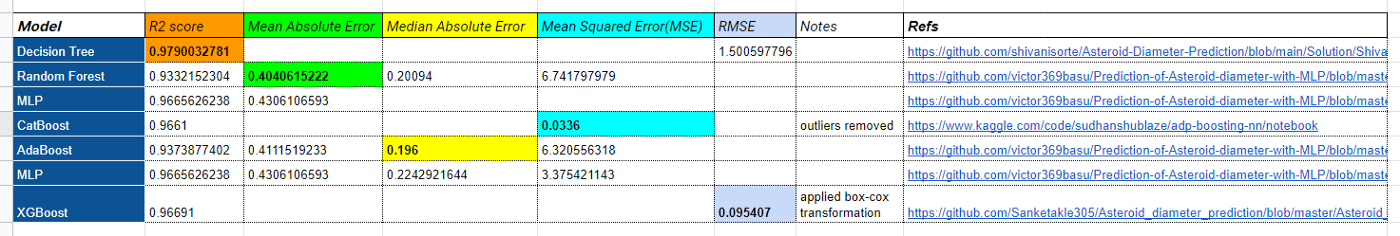